### Spectrogram / Audio model

This notebook contains  code for the audio model. A model containing 3 Convolution
Neural Networks (CNNs) was used with account to limited compute in time of training.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# augmentations to the data in a format that
# can be used by the model
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {'train': datasets.ImageFolder("../../data/train/spectrogram/",
                                          data_transforms['train']),
                  'val': datasets.ImageFolder("../../data/validation/spectrogram/",
                                          data_transforms['val']),
                  'test': datasets.ImageFolder("../../data/test/spectrogram/",
                                              data_transforms['val'])
                 }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

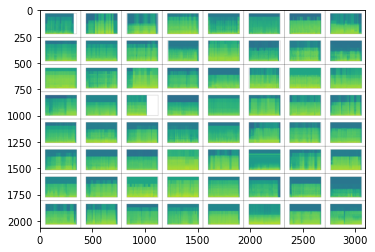

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# transfer learning
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [6]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=150)

Epoch 0/149
----------


/home/martinoywa/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.5523 Acc: 0.3047
val Loss: 1.6287 Acc: 0.3396

Epoch 1/149
----------
train Loss: 1.3677 Acc: 0.3661
val Loss: 1.3800 Acc: 0.3514

Epoch 2/149
----------
train Loss: 1.2914 Acc: 0.4044
val Loss: 1.4150 Acc: 0.3491

Epoch 3/149
----------
train Loss: 1.2699 Acc: 0.4236
val Loss: 1.4533 Acc: 0.3325

Epoch 4/149
----------
train Loss: 1.2597 Acc: 0.4322
val Loss: 1.4349 Acc: 0.3467

Epoch 5/149
----------
train Loss: 1.2783 Acc: 0.4260
val Loss: 1.4669 Acc: 0.2807

Epoch 6/149
----------
train Loss: 1.2480 Acc: 0.4413
val Loss: 1.4054 Acc: 0.3231

Epoch 7/149
----------
train Loss: 1.1971 Acc: 0.4724
val Loss: 1.3693 Acc: 0.3585

Epoch 8/149
----------
train Loss: 1.1883 Acc: 0.4724
val Loss: 1.3848 Acc: 0.3443

Epoch 9/149
----------
train Loss: 1.1768 Acc: 0.4844
val Loss: 1.3781 Acc: 0.3608

Epoch 10/149
----------
train Loss: 1.1780 Acc: 0.4830
val Loss: 1.3812 Acc: 0.3325

Epoch 11/149
----------
train Loss: 1.1759 Acc: 0.4849
val Loss: 1.4067 Acc: 0.3443

Epoch 12/149


In [7]:
# save model
torch.save(model_conv.state_dict(), f"finetuned_Frozen-RESNET_model.pt")

In [8]:
# load and test model
model_conv.load_state_dict(torch.load("finetuned_Frozen-RESNET_model.pt", map_location="cpu"), strict=False)

<All keys matched successfully>

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_conv.cpu()
model_conv.eval() # prep model for *evaluation*

for data, target in dataloaders['test']:
    batch_size = data.size(0)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_conv(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(dataloaders['test'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.290234

Test Accuracy of     0: 60% (204/340)
Test Accuracy of     1: 17% (36/206)
Test Accuracy of     2: 44% (117/265)
Test Accuracy of     3: 24% (50/201)

Test Accuracy (Overall): 40% (407/1012)
